In [6]:
import sqlite3
import re
import pandas as pd
import numpy as np

## Clean up subject

In [7]:
# conn = sqlite3.connect('../hillary-clinton-emails/database.sqlite')
# cur = conn.cursor()
# cur.execute('pragma table_info(Emails)')
# f_1 = 'Id'
# f_2 = 'MetadataTo'
# f_3 = 'MetadataFrom'
# f_4 = 'ExtractedSubject'
# f_5 = 'ExtractedDateSent'
# f_6 = 'ExtractedBodyText'
# f_7 = 'RawText'
# cur.execute('select {c1},{c2},{c3},{c4},{c5},{c6},{c7} from Emails'.\
#             format(c1=f_1,c2=f_2,c3=f_3,c4=f_4,c5=f_5,c6=f_6,c7=f_7))
# cur.fetchall()
# cur.fetchone()
# columns_less = ['id','to','from','sub','date','body','raw']
# columns = [str(tpl[1]) for tpl in columns]
def clean_subject(sub):
    email_type = None
    if re.match('^[Ff][Ww]',sub)!=None:
        email_type='fw'
        sub = re.sub('^[Ff][Ww].*:\s*(.+)',r'\1',sub)
    elif re.match('^[Rr][Ee]:',sub)!=None:
        email_type='re'
        sub = re.sub('^[Rr][Ee]:\s*(.+)',r'\1',sub)
    elif re.match('^[Ff][Vv][Vv]:',sub)!=None:
        email_type='fvv'
        sub = re.sub('^[Ff][Vv][Vv]:\s*(.+)',r'\1',sub)
    return email_type,sub

In [8]:
conn = sqlite3.connect('../hillary-clinton-emails/database.sqlite')
sql = """select e.Id, p.Name Sender, e.SenderPersonId Sender_Id
, e.MetadataTo Receiver, a.PersonId Receiver_Id, e.ExtractedDateSent, e.ExtractedSubject
from Emails e 
inner join Persons p on e.SenderPersonId=p.Id 
left outer join Aliases a on lower(e.MetadataTo)=a.Alias
"""
emails = pd.read_sql_query(sql,conn)
temp = emails.ExtractedSubject.apply(clean_subject)
emails['ExtractedSubject'] = [tpl[1] for tpl in temp]
emails['email_type'] = email_type = [tpl[0] for tpl in temp]
emails.head(10)

In [22]:
sql1 = """select e.Id, p.Name Sender, e.MetadataTo Receiver, e.ExtractedDateSent, e.ExtractedSubject, e.ExtractedBodyText
from Emails e 
inner join Persons p on e.SenderPersonId=p.Id 
left outer join Aliases a on lower(e.MetadataTo)=a.Alias
where (e.ExtractedBodyText LIKE '%Libya%' or  e.ExtractedBodyText LIKE '%Haiti%' or  e.ExtractedBodyText LIKE '%Afghanistan%'
or e.ExtractedBodyText LIKE '%Iraq%' or e.ExtractedBodyText LIKE '%China%' or e.ExtractedBodyText LIKE '%Pakistan%') and 
LENGTH(e.ExtractedBodyText) > 4750
"""
newemails = pd.read_sql_query(sql1,conn)
print(newemails.head(10))

    Id                Sender Receiver                      ExtractedDateSent  \
0   14  Anne-Marie Slaughter        H                                          
1   29         Burns Strider        H  Thursday, September 13, 2012 12:41 PM   
2   47     Sidney Blumenthal        H       Monday, October 1, 2012 10:14 AM   
3   58         Jake Sullivan        H        Monday, October 1, 2012 3:57 PM   
4  127         Jake Sullivan        H                                          
5  147           Huma Abedin        H        Sunday, August 21, 2011 9:26 AM   
6  175       Philippe Reines        H   Saturday, September 22, 2012 7:45 AM   
7  207  Anne-Marie Slaughter        H                                          
8  215         Jake Sullivan        H    Monday, September 24, 2012 10:17 AM   
9  240          Cheryl Mills        H      Tuesday, December 4, 2012 7:17 AM   

                                    ExtractedSubject  \
0                                                      
1      

## Clean-up sender receiver

In [4]:
# Fetch data in pandas dataframe
conn = sqlite3.connect('../hillary-clinton-emails/database.sqlite')
# sql = "select * from Emails"
# emails = pd.read_sql_query(sql,conn)
# columns = ['Id','SenderPersonId','MetadataFrom','MetadataTo','ExtractedDateSent','ExtractedSubject','ExtractedBodyText']
# emails[columns].head(5)
# emails[emails['SenderPersonId']==80][columns].head(5)
# x = emails.groupby('SenderPersonId').size()
# print 'No of mails sent by HC =',x[80]

# Assign receiver Id
sql = """select e.Id, p.Name Sender, 
e.SenderPersonId Sender_Id, e.MetadataTo Receiver, a.PersonId Receiver_Id, e.ExtractedDateSent
from Emails e 
inner join Persons p on e.SenderPersonId=p.Id 
left outer join Aliases a on lower(e.MetadataTo)=a.Alias
"""
emails = pd.read_sql_query(sql,conn)
# emails_noNA = emails.dropna(how='any')
# emails.head(20)
idx_NaN = [i for i,val in enumerate(emails['Receiver_Id']) if np.isnan(val)]


# Create dictionary personId:name
sql = "select * from Persons"
persons = pd.read_sql_query(sql,conn)
name2id = {}
id2name = {}
for entry in persons.itertuples():
    name2id[entry[2]]=entry[1]
    id2name[entry[1]]=entry[2]
    
# Fill up missing Receiver_Id fields
receiver_dict = {}
pattern = re.compile('^(\w+),\sp*(\w+)')
for idx in idx_NaN:
    name = emails['Receiver'][idx]
    pat_obj = pattern.match(name)
    if pat_obj!=None:
        person_name = pat_obj.group(2)+' '+pat_obj.group(1)
        try:
            person_id = name2id[person_name]
            emails['Receiver_Id'][idx]=person_id
        except:
            pass
temp = emails.shape[0]
emails = emails.dropna(how='any')
print 'Discarded emails: ',temp-emails.shape[0]

SyntaxError: Missing parentheses in call to 'print' (<ipython-input-4-10d03bc3db64>, line 48)

## Rank contacts on interraction frequency

In [5]:
emails_from_H = emails[emails['Sender_Id']==80]
x = emails_from_H.groupby('Receiver_Id')['Id'].count()
person_ids = np.array(x.index.values)
counts = np.array([i for i in x])
# ind_sorted = np.array(np.argsort(counts)[::-1][:len(counts)])
# counts = counts[ind_sorted]
# person_ids = person_ids[ind_sorted]
# for i in person_ids[:10]:
#     print id2name[i]
person_names = [id2name[i] for i in person_ids]
%matplotlib inline
df = pd.DataFrame(np.array(counts),person_names)
df = df[df[0]>9]
ax = df.plot(kind='bar',legend=False,title='Email Frequency from H')
ax.set_ylabel('Count')

NameError: name 'id2name' is not defined

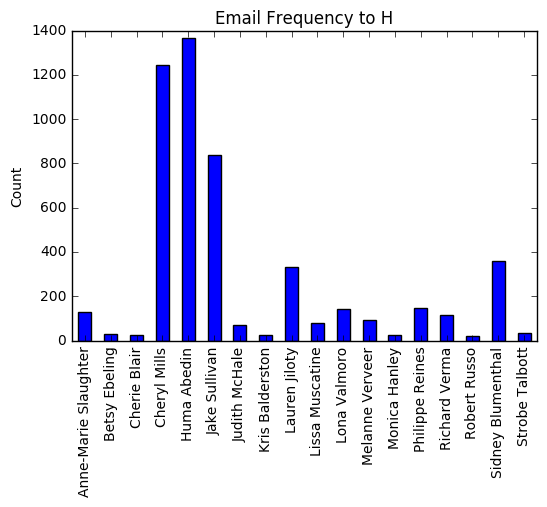

In [7]:
emails_from_H = emails[emails['Receiver_Id']==80]
x = emails_from_H.groupby('Sender_Id')['Id'].count()
person_ids = np.array(x.index.values)
counts = np.array([i for i in x])
# ind_sorted = np.array(np.argsort(counts)[::-1][:len(counts)])
# counts = counts[ind_sorted]
# person_ids = person_ids[ind_sorted]
# for i in person_ids[:10]:
#     print id2name[i]
person_names = [id2name[i] for i in person_ids]
%matplotlib inline
df = pd.DataFrame(np.array(counts),person_names)
df = df[df[0]>20]
ax = df.plot(kind='bar',legend=False,title='Email Frequency to H')
ax.set_ylabel('Count')

## Clean up date

In [9]:
# txt = 'Thursday, September 30, 2010 9:04 PM'
# txt = 'Thu Sep 17 06:03:43 2009'
def clean_date_aux(ts):
    pat = re.compile('\'?(?P<weekday>\w+),?\s*(?P<month>\w+) (?P<date>\d+),?\s*(?P<year>\d+) (?P<time>.+) (?P<ampm>[A|P]M)')
    pat1 = re.compile('(?P<weekday>.+) (?P<month>.+) (?P<date>.+) (?P<time>.+) (?P<year>.+)')
    if ts=='':
        return np.NAN
    re_obj = None
    try:
        if pat.match(ts)!=None:
            re_obj = pat.match(ts)
        elif pat1.match(ts)!=None:
            re_obj = pat1.match(ts)
        else:
            raise
        # Process date
        month = re_obj.group('month')
        day = re_obj.group('date')
        year = re_obj.group('year')
        time = re_obj.group('time').replace('.',':')
        # Check for numeric value of day and year
        try:
            month = month[:3]
            day = int(day)
            year = int(year)
        except:
            raise
        # Check time string
        if ':' not in time and len(time)>2:
            time = time[:-2]+':'+time[-2:]
        try:
            time = time + ' ' + re_obj.group('ampm')
        except:
            pass
        ts_str = "{} {} {} {}".format(month,day,year,time)
        try:
            pd_ts = pd.to_datetime(ts_str)
            return pd_ts
        except:
            raise
    except:
        return np.NAN

In [11]:
def clean_date(raw_date):
    return clean_date_aux(raw_date)
emails['Date']=emails.ExtractedDateSent.apply(clean_date)
emails.head(10)
# emails = emails.dropna(how='any')
emails.index = emails.Date
emails.sort_index(inplace=True)
mindate,maxdate = emails.index.min(),emails.index.max()
"Date Range from {} to {}".format(mindate.date(),maxdate.date())
emails[:'2011-01'].Id.count()

,Id,Sender,Sender_Id,Receiver,Receiver_Id,ExtractedDateSent,Date
Date,,,,,,,
2009-03-13 23:47:59,1336,Cheryl Mills,32,H,80.0,"Friday, March 13, 2009 11:47:59 PM",2009-03-13 23:47:59
2009-03-19 12:24:00,1243,Huma Abedin,81,H,80.0,"Thursday, March 19, 2009 12:24 PM",2009-03-19 12:24:00
2009-03-21 11:21:00,1248,Philippe Reines,170,H,80.0,"Saturday, March 21, 2009 11:21 AM",2009-03-21 11:21:00
2009-03-21 16:09:00,1249,Jake Sullivan,87,H,80.0,"Saturday, March 21,2009 4:09 PM",2009-03-21 16:09:00
2009-03-21 19:13:00,1250,Lona Valmoro,124,H,80.0,"Saturday, March 21, 2009 7:13 PM",2009-03-21 19:13:00
2009-03-23 19:39:00,1251,Lauren Jiloty,116,H,80.0,"Monday, March 23, 2009 7:39 PM",2009-03-23 19:39:00
2009-03-23 22:00:00,1252,Jake Sullivan,87,H,80.0,"Monday, March 23, 2009 10:00 PM",2009-03-23 22:00:00
2009-03-25 08:09:00,1254,Lona Valmoro,124,H,80.0,"Wednesday, March 25, 2009 8:09 AM",2009-03-25 08:09:00
2009-03-25 10:33:00,1255,Cheryl Mills,32,H,80.0,"Wednesday, March 25, 2009 10:33 AM",2009-03-25 10:33:00


## Process email body: Topic modelling

In [12]:
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
import gensim
# import logging
# logging.basicConfig(format='%(levelname)s : %(message)s', level=logging.INFO)
# logging.root.level = logging.INFO  # ipython sometimes messes up the logging setup; restore

In [13]:
class HillaryEmails(object):
    def __init__(self,doc_vectors):
        self.doc_vectors = doc_vectors
    def __iter__(self):
        for vector in self.doc_vectors:
            yield vector

In [14]:
def tokenize(text):
    text = text.replace("\n"," ")
    return [token for token in simple_preprocess(text) if token not in STOPWORDS]
def do_BoW(tokens):
    return vocab.doc2bow(tokens)
def get_maxwords(vector):
    minimum = int(len(vector)*0.2)
    minimum = min(10,minimum)
    global vocab
    temp = sorted(vector,key=lambda x:x[1],reverse=True)
    topic = [vocab[it[0]] for it in temp[:minimum]]
    return topic
conn = sqlite3.connect('../hillary-clinton-emails/database.sqlite')
sql = """select e.Id, p.Name Sender, 
e.SenderPersonId Sender_Id, e.ExtractedDateSent, e.ExtractedBodyText
from Emails e 
inner join Persons p on e.SenderPersonId=p.Id
"""
emails = pd.read_sql_query(sql,conn)
emails['ExtractedDateSent']=emails.ExtractedDateSent.apply(clean_date)
# Step 1: Mails from Hillary
# emails = emails[emails['Sender_Id']==80]
# Step 2: Tokenize email body
email_tokens = emails.ExtractedBodyText.apply(tokenize)
doc_stream = [tokens for tokens in email_tokens]
print len(doc_stream)
# Step 3: Build Vocabulary
%time vocab = gensim.corpora.Dictionary(doc_stream)
    # vocab.filter_extremes(no_below=20,no_above=0.8)
# Step 4: Run BoW on docs
vectors_doc = email_tokens.apply(do_BoW)
maxwords = vectors_doc.apply(get_maxwords)
#Step 5: save doc vectors in mm file
hillary_emails_corpus = HillaryEmails(vectors_doc)
%time gensim.corpora.MmCorpus.serialize('emails_bow.mm',hillary_emails_corpus)

7788
CPU times: user 752 ms, sys: 16 ms, total: 768 ms
Wall time: 755 ms
CPU times: user 1.48 s, sys: 12 ms, total: 1.49 s
Wall time: 1.49 s


In [15]:
# hillary_mm_corpus = gensim.corpora.MmCorpus('emails_bow.mm')
# clipped_corpus = gensim.utils.ClippedCorpus(hillary_emails_corpus,1600)
tfidf = gensim.models.TfidfModel(vectors_doc)
#print(tfidf)
corpus_tfidf = tfidf[vectors_doc]
%time lda_model = gensim.models.LdaModel(corpus_tfidf, num_topics=20, id2word=vocab, passes=4)

CPU times: user 1min 50s, sys: 1.34 s, total: 1min 52s
Wall time: 1min 8s


In [16]:
lda_model.get_document_topics(vectors_doc[10])
for topic in range(lda_model.num_topics):
    print topic,lda_model.show_topic(topic,topn=10)
lda_model.get_topic_terms(10)
lda_model.get_term_topics(vocab.token2id['state'])

0 [(u'looks', 0.005093484471521071), (u'weekend', 0.0046174223344043596), (u'eikenberry', 0.0040542859774752695), (u'onward', 0.0027114610609715499), (u'gone', 0.0026596049138335682), (u'timing', 0.0023344913689144616), (u'intonemai', 0.0022064317862161478), (u'mon', 0.0019049794912759637), (u'jackie', 0.0018213677259734482), (u'poland', 0.001708297632133372)]
1 [(u'sorry', 0.0060129740721133135), (u'note', 0.0053222545203509553), (u'kurt', 0.0042446028003738766), (u'xo', 0.0039660579158644618), (u'jeff', 0.00371984582132878), (u'percent', 0.0026200771954549532), (u'deliver', 0.0022768883662749638), (u'feltmann', 0.0022654762403369788), (u'tom', 0.0021159580448584289), (u'write', 0.0020921586457899174)]
2 [(u'll', 0.0069298613011614853), (u'roger', 0.0061885887648815531), (u'sbwhoeop', 0.0057360728891954951), (u'travel', 0.0048468051567948046), (u'anne', 0.0045768449909619029), (u'sid', 0.0045204639958544759), (u'marie', 0.0043805925998540241), (u'haven', 0.0039213248680885727), (u'ahe

AttributeError: 'LdaModel' object has no attribute 'get_term_topics'

In [19]:
# Visualization
# see https://pyldavis.readthedocs.io/en/latest/modules/API.html#pyLDAvis.prepare
%matplotlib inline

import pyLDAvis

n_doc = len(vectors_doc)
n_topic = lda_model.num_topics
n_vocab = len(vocab.keys())

# step 0
topic_term_dists = np.zeros([n_topic,n_vocab])
for topic_num in range(n_topic):
    word_dist = lda_model.get_topic_terms(topic_num,topn=n_vocab)
    words = [i for i,_ in word_dist]
    prob = [i for _,i in word_dist]
    topic_term_dists[topic_num][words] = prob

# step 1
doc_topic_dists = np.zeros([n_doc,n_topic]) # n_doc x n_topic
for doc_num in range(n_doc):
    topic_dist = lda_model.get_document_topics(vectors_doc[doc_num],minimum_probability=0)
    topics = [i for i,_ in topic_dist]
    probs = [i for _,i in topic_dist]
    doc_topic_dists[doc_num][topics] = probs

# step 2
doc_lengths = (np.zeros(n_doc)).astype(int)
for doc_num in range(n_doc):
    l = np.sum([i for _,i in vectors_doc[doc_num]])
    doc_lengths[doc_num] = int(l)
    
# step 3
vocab_list = np.array(vocab.values())

# step 4
term_frequency = np.zeros(n_vocab)
for doc_num in range(n_doc):
    words = [i for i,_ in vectors_doc[doc_num]]
    freq = [i for _,i in vectors_doc[doc_num]]
    term_frequency[words] += freq

movies_vis_data = pyLDAvis.prepare(topic_term_dists, doc_topic_dists, doc_lengths, vocab_list, term_frequency)
pyLDAvis.display(movies_vis_data)

/home/debojyoti/anaconda2/lib/python2.7/site-packages/pyLDAvis/_prepare.py:132: FutureWarning: order is deprecated, use sort_values(...)
  return relevance.T.apply(lambda s: s.order(ascending=False).index).head(R)
/home/debojyoti/anaconda2/lib/python2.7/site-packages/pyLDAvis/_prepare.py:132: FutureWarning: order is deprecated, use sort_values(...)
  return relevance.T.apply(lambda s: s.order(ascending=False).index).head(R)
/home/debojyoti/anaconda2/lib/python2.7/site-packages/pyLDAvis/_prepare.py:132: FutureWarning: order is deprecated, use sort_values(...)
  return relevance.T.apply(lambda s: s.order(ascending=False).index).head(R)
/home/debojyoti/anaconda2/lib/python2.7/site-packages/pyLDAvis/_prepare.py:132: FutureWarning: order is deprecated, use sort_values(...)
  return relevance.T.apply(lambda s: s.order(ascending=False).index).head(R)
/home/debojyoti/anaconda2/lib/python2.7/site-packages/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by

In [34]:
hillary_mm_corpus = gensim.corpora.MmCorpus('emails_bow.mm')
%time tfidf_model = gensim.models.TfidfModel(hillary_mm_corpus, id2word=vocab)
%time lsi_model = gensim.models.LsiModel(tfidf_model[hillary_mm_corpus], id2word=vocab, num_topics=200)

CPU times: user 1.51 s, sys: 12 ms, total: 1.52 s
Wall time: 1.54 s
CPU times: user 8.35 s, sys: 536 ms, total: 8.89 s
Wall time: 6.54 s


## Running R from python

In [34]:
import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
import rpy2.robjects.packages as rpackages
from rpy2.robjects.vectors import StrVector
base = importr('base')
utils = rpackages.importr('utils')
utils.chooseCRANmirror(ind=1)

rpy2.rinterface.NULL

In [35]:
packnames = ['ggplot2']
names_to_install = [x for x in packnames if not rpackages.isinstalled(x)]
if len(names_to_install)>0:
    utils.install_packages(StrVector(names_to_install))

## Sentiment Analysis on countries

In [22]:
import nltk
from nltk.tokenize import sent_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re

In [23]:
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
n_instances = 100
subj_docs = [(sent,'subj') for sent in subjectivity.sents(categories='subj')[:n_instances]]
obj_docs = [(sent,'obj') for sent in subjectivity.sents(categories='obj')[:n_instances]]
# subj_docs[10],obj_docs[1]
train_docs = subj_docs[:80]+obj_docs[:80]
test_docs = subj_docs[80:100]+obj_docs[80:100]
senti_analyser = SentimentAnalyzer()

In [24]:
sent = "He is a murderer"
sentiAnalyser = SentimentIntensityAnalyzer()
sentiAnalyser.polarity_scores(sent)

{'compound': -0.6808, 'neg': 0.697, 'neu': 0.303, 'pos': 0.0}

## Find sentiment of emails

In [25]:
def getSentiment(text):
    pos = 0
    neg = 0
    neu = 0
    if text=='':
        return 0,pos,neg
    global sentiAnalyser
    text = text.replace('\n',' ')
    sentences = sent_tokenize(text)
    sentences = [sent for sent in sentences if len(sent.split())>2]
    for sent in sentences:
        senti = sentiAnalyser.polarity_scores(sent)
        if senti['neu']>=0.9:
            neu += 1
        else:
            pos += senti['pos']
            neg += senti['neg']
    count = len(sentences)-neu
    if count == 0:
        return len(sentences),pos,neg
    return len(sentences),pos/count,neg/count
conn = sqlite3.connect('../hillary-clinton-emails/database.sqlite')
sql = """select e.Id, p.Name Sender, 
e.SenderPersonId Sender_Id, e.ExtractedDateSent, e.ExtractedBodyText
from Emails e 
inner join Persons p on e.SenderPersonId=p.Id
"""
emails = pd.read_sql_query(sql,conn)
emails['ExtractedDateSent']=emails.ExtractedDateSent.apply(clean_date)
# Step 1: Mails from Hillary
emails = emails[emails['Sender_Id']==80]
# emails = emails.head(5)
# emails.ExtractedBodyText.apply(getSentiment)
print 'Total Email count by Hillary: ',emails.Id.count()
sentiAnalyser = SentimentIntensityAnalyzer()
%time sentiments = emails.ExtractedBodyText.apply(getSentiment)
senti_map = zip(emails.Id.values,sentiments.values)
senti_map = sorted(senti_map,key = lambda(item):item[1][2],reverse=True)
print senti_map[:5]

Total Email count by Hillary:  1993
CPU times: user 1.18 s, sys: 28 ms, total: 1.21 s
Wall time: 1.23 s
[(552, (7, 0.0, 0.772)), (2240, (1, 0.0, 0.7)), (585, (3, 0.0, 0.531)), (1022, (2, 0.0, 0.508)), (2308, (1, 0.0, 0.483))]


## Find occurance of country name in mails

In [26]:
import pycountry

In [27]:
def get_count(text):
    global country_counter
    global countries_new_name
    for indx,country in enumerate(pycountry.countries):
        name = country.name
        if name in countries_new_name.keys():
            name = countries_new_name[name]
        name = '\\b'+name # Ensuring substring start with country name. eg.Indian, Syrian, India
        all_matches = re.finditer(name,text,re.IGNORECASE)
        n_occurrences = len(list(all_matches))
        country_counter[indx] += n_occurrences
country_counter = [0 for country in pycountry.countries]
country_names = [country.name for country in pycountry.countries]
countries_new_name = {'Syrian Arab Republic':'Syria','Russian Federation':'Russia','Iran, Islamic Republic of':\
                      'Iran','Korea, Democratic People\'s Republic of':'Korea','Palestine, State of':'Palestine',\
                      'Venezuela, Bolivarian Republic of':'Venezuela'}
emails.ExtractedBodyText.apply(get_count)
# let's study count for some countries
country2ind = {}
for indx,country in enumerate(pycountry.countries):
    country2ind[country.name]=indx
country_name_count = zip(country_names,country_counter)
country_name_count = sorted(country_name_count,key = lambda(item):item[1],reverse=True)

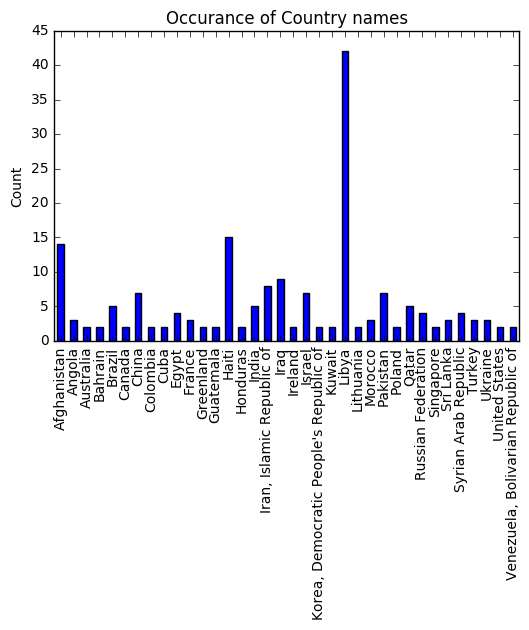

In [28]:
%matplotlib inline
df = pd.DataFrame(np.array(country_counter),country_names)
df = df[df[0]>1]
ax = df.plot(kind='bar',legend=False,title='Occurance of Country names')
ax.set_ylabel('Count')

## Correlation between country vs average sentiment

In [29]:
def get_occurence_ct(text,country):
    name = country.name
    counter = 0
    global countries_new_name
    if name in countries_new_name.keys():
        name = countries_new_name[name]
    name = '\\b'+name # Ensuring substring start with country name. eg.Indian, Syrian, India
    all_matches = re.finditer(name,text,re.IGNORECASE)
    n_occurrences = len(list(all_matches))
    counter += n_occurrences
    abbr_to_ignore = ["RE", "FM", "TV", "AL", "AQ", "LA", "BEN"]
    if country.alpha2 not in abbr_to_ignore:
        name = '\\b'+country.alpha2+'\\b'
        all_matches = re.finditer(name,text)
        n_occurrences = len(list(all_matches))
        counter += n_occurrences
    if country.alpha3 not in abbr_to_ignore:
        name = '\\b'+country.alpha3+'\\b'
        all_matches = re.finditer(name,text)
        n_occurrences = len(list(all_matches))
        counter += n_occurrences
    return counter
def get_country_sentiment(country):
    global sentiments
    global emails
    res_pos,res_neg = 0,0
    counts = emails.ExtractedBodyText.apply(get_occurence_ct,args=(country,))
    sentiments_pos = [tpl[1] for tpl in sentiments.values]
    sentiments_neg = [tpl[2] for tpl in sentiments.values]
    if sum(counts.values)>0:
        res_pos = sum([ct*pos for ct,pos in zip(counts.values,sentiments_pos)])/sum(counts.values)
        res_neg = sum([ct*neg for ct,neg in zip(counts.values,sentiments_neg)])/sum(counts.values)
    return res_pos,res_neg
countries = pd.Series([country for country in pycountry.countries])
senti = countries.apply(get_country_sentiment)

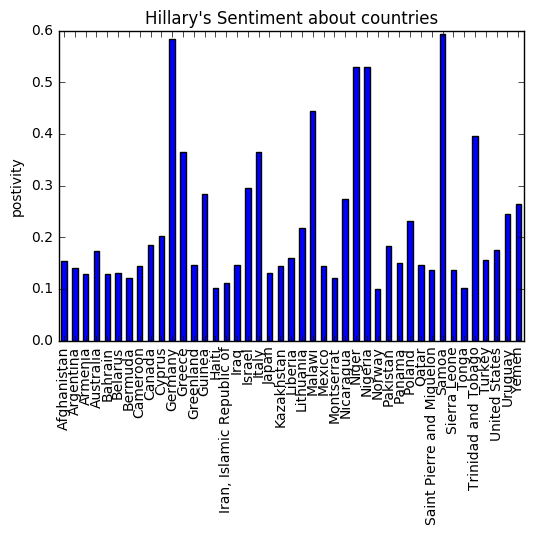

In [30]:
senti_pos = np.array([i[0] for i in senti])
df = pd.DataFrame(senti_pos,country_names)
df = df[df[0]>0.1]
ax = df.plot(kind='bar',legend=False,title='Hillary\'s Sentiment about countries')
ax.set_ylabel('postivity')

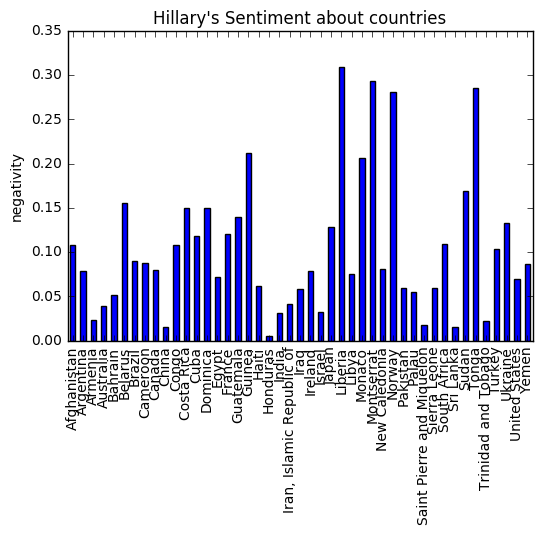

In [31]:
senti_neg = np.array([i[1] for i in senti])
df = pd.DataFrame(senti_neg,country_names)
df = df[df[0]>0]
ax = df.plot(kind='bar',legend=False,title='Hillary\'s Sentiment about countries')
ax.set_ylabel('negativity')